In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [5]:
df=pd.read_csv('customer_revenue_tier.csv').drop('Unnamed: 0',axis=1)
feature =pd.read_csv('data_features.csv').drop('Unnamed: 0',axis=1) 
#this dataframe can be generated from 'Churn_Model_AB4J_10foldcv_0723'

In [6]:
df['TRX_DATE']=pd.to_datetime(df['TRX_DATE'])

In [7]:
df['Main_Product']=np.where(df['PRODUCT_FAMILY'].isin(['CIJ','LCM','TTO','TIJ']),df['PRODUCT_FAMILY'],'Other')

In [8]:
#get the duration(tenure) for each customer
dfd=df.groupby(['CUSTOMER_SITE_ID','SHORT_VERTICAL','CUSTOMER_CLASS','Tier','Active'])\
.agg({'TRX_DATE':['min','max']}).reset_index()
dfd.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in dfd.columns]
dfd['Duration']=((dfd['TRX_DATE_max']-dfd['TRX_DATE_min'])/np.timedelta64(1,'D')).astype('int')+1
dfd=dfd.drop(['TRX_DATE_min','TRX_DATE_max'],axis=1)

In [9]:
#identify the customer who spent over 50% on either CIJ, LCM, TTO, or TIJ
dfctp=df.groupby(['CUSTOMER_SITE_ID','Tier','Active','Main_Product'])['TRX_AMT_USD'].sum().reset_index()
dfctp['Tier_TRX_Total']=dfctp['TRX_AMT_USD'].groupby(dfctp['CUSTOMER_SITE_ID']).transform('sum')
dfctp['TRX_Percent'] =round((dfctp['TRX_AMT_USD']/dfctp['Tier_TRX_Total'])*100,2)

main_product=dfctp[(dfctp['TRX_Percent']>50)&(dfctp['Main_Product'].isin(['CIJ','LCM','TTO','TIJ']))]\
[['CUSTOMER_SITE_ID','Tier','Active','Main_Product']]


In [10]:
dfs = main_product.merge(dfd,on=['CUSTOMER_SITE_ID','Tier','Active'])

In [11]:
dfs.head()

,CUSTOMER_SITE_ID,Tier,Active,Main_Product,SHORT_VERTICAL,CUSTOMER_CLASS,Duration
0,20,Tier 2,1,TTO,PHARMA & MEDICAL,END USER,1896
1,24,Tier 3,1,LCM,GRAPHICS,END USER,53
2,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910
3,86,Tier 2,1,TIJ,PHARMA & MEDICAL,END USER,1815
4,90,Tier 1,1,CIJ,CHEMICALS,END USER,1829


In [47]:
dfs.Main_Product.value_counts()

CIJ    11347
TTO     1831
LCM     1663
TIJ      631
Name: Main_Product, dtype: int64

In [13]:
dfs['Churn']=np.where(dfs['Active']==1,0,1)

In [51]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [55]:
dfs

,CUSTOMER_SITE_ID,Tier,Active,Main_Product,SHORT_VERTICAL,CUSTOMER_CLASS,Duration,Churn
0,20,Tier 2,1,TTO,PHARMA & MEDICAL,END USER,1896,0
1,24,Tier 3,1,LCM,GRAPHICS,END USER,53,0
2,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0
3,86,Tier 2,1,TIJ,PHARMA & MEDICAL,END USER,1815,0
4,90,Tier 1,1,CIJ,CHEMICALS,END USER,1829,0
...,...,...,...,...,...,...,...,...
15467,8424224,Tier 2,1,CIJ,INDUSTRIAL EQUIPMENT,END USER,386,0
15468,8424349,Tier 4,1,CIJ,UNKNOWN,END USER,1,0
15469,8424358,Tier 4,1,CIJ,UNKNOWN,END USER,1,0
15470,8424360,Tier 4,1,CIJ,UNKNOWN,END USER,2,0


In [53]:
install=pd.read_csv('installbase.csv')

In [118]:
dfs1=dfs.merge(install,on='CUSTOMER_SITE_ID',how='left')

In [119]:
dfs1

,CUSTOMER_SITE_ID,Tier,Active,Main_Product,SHORT_VERTICAL,CUSTOMER_CLASS,Duration,Churn,INSTANCE_ID,STATUS,INSTALL_DATE,CONTRACT_FLAG,CONTRACT_START_DATE,CONTRACT_END_DATE,DUNS_NUMBER,SITE_NUMBER,SFDC_ID,PRODUCT_FAMILY,INSTANCE_LAST_UPDATE_DATE,CONTRACT_CATEGORY,PFV_MODEL_GROUP
0,20,Tier 2,1,TTO,PHARMA & MEDICAL,END USER,1896,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,Tier 3,1,LCM,GRAPHICS,END USER,53,0,374068653.0,Active - Confirmed,2020-06-02,N,NaN,NaN,144782380.0,100068559,0018000000WFc63AAD,LASER,2020-06-02,NaN,TOTAL LASER
2,24,Tier 3,1,LCM,GRAPHICS,END USER,53,0,439346579.0,Active - Confirmed,2019-06-25,N,NaN,NaN,144782380.0,100068559,0018000000WFc63AAD,LASER,2020-07-27,NaN,TOTAL LASER
3,24,Tier 3,1,LCM,GRAPHICS,END USER,53,0,439346383.0,Active - Confirmed,2019-06-25,N,NaN,NaN,144782380.0,100068559,0018000000WFc63AAD,LASER,2020-07-27,NaN,TOTAL LASER
4,24,Tier 3,1,LCM,GRAPHICS,END USER,53,0,512382218.0,Active - Confirmed,2020-04-22,N,NaN,NaN,144782380.0,100068559,0018000000WFc63AAD,LCM,2020-07-27,NaN,LCM - 2300 / ML4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79601,8424224,Tier 2,1,CIJ,INDUSTRIAL EQUIPMENT,END USER,386,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79602,8424349,Tier 4,1,CIJ,UNKNOWN,END USER,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79603,8424358,Tier 4,1,CIJ,UNKNOWN,END USER,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79604,8424360,Tier 4,1,CIJ,UNKNOWN,END USER,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
cij=dfs1[dfs1['Main_Product']=='CIJ']
tto=dfs1[dfs1['Main_Product']=='TTO']
lcm=dfs1[dfs1['Main_Product']=='LCM']
tij=dfs1[dfs1['Main_Product']=='TIJ']

Text(0, 0.5, 'Customer Survival Chance (%)')

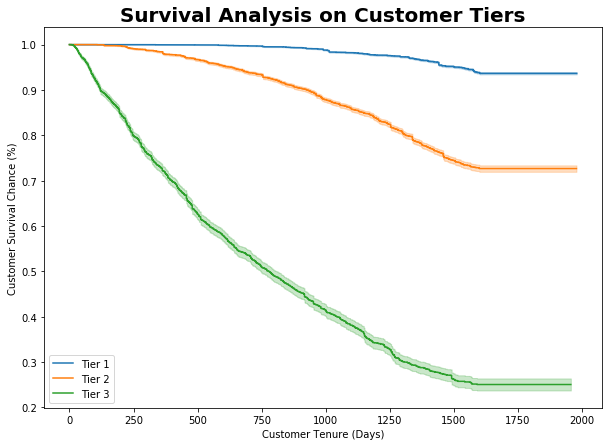

In [75]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = dfs1['Duration'].values
E = dfs1['Churn'].values

## Tiers are compared
groups = dfs1['Tier']   
i1 = (groups == 'Tier 1')   
i2 = (groups == 'Tier 2') 
i3 = (groups == 'Tier 3')     
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Tier 1')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Tier 2')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Tier 3')
kmf1.plot(ax=a1)



plt.title("Survival Analysis on Customer Tiers",weight='bold',size=20)
plt.legend(loc=3)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

In [120]:
dfs1['CONTRACT_CATEGORY'] = dfs1['CONTRACT_CATEGORY'].fillna('non-contract')
dfs1['CONTRACT_CATEGORY'].value_counts()

non-contract    45703
FSMA            29333
Full Care        4504
Supportive         58
WFC                 8
Name: CONTRACT_CATEGORY, dtype: int64

Text(0, 0.5, 'Customer Survival Chance (%)')

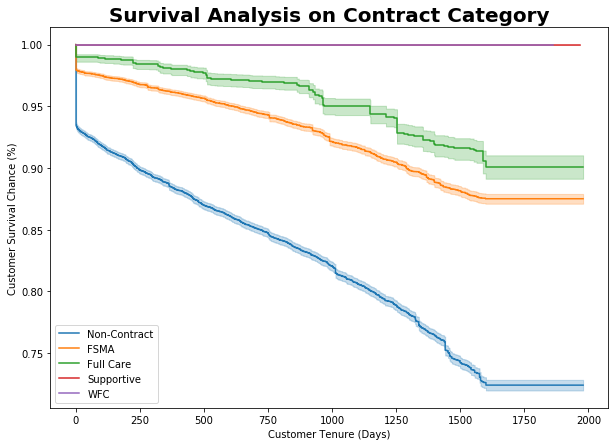

In [122]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = dfs1['Duration'].values
E = dfs1['Churn'].values

## Tiers are compared
groups = dfs1['CONTRACT_CATEGORY']   
i1 = (groups == 'non-contract')   
i2 = (groups == 'FSMA') 
i3 = (groups == 'Full Care')   
i4 = (groups == 'Supportive')  
i5 = (groups == 'WFC') 
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Non-Contract')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='FSMA')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Full Care')
kmf1.plot(ax=a1)

kmf1.fit(T[i4], E[i4], label='Supportive')
kmf1.plot(ax=a1)

kmf1.fit(T[i5], E[i5], label='WFC')
kmf1.plot(ax=a1)



plt.title("Survival Analysis on Contract Category",weight='bold',size=20)
plt.legend(loc=3)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

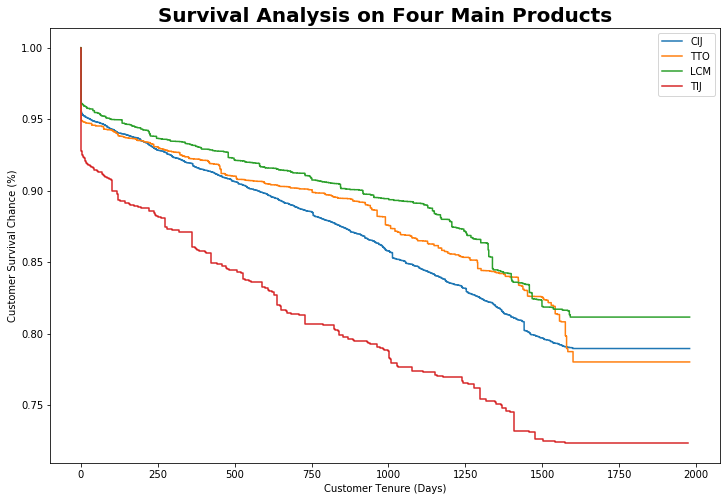

In [76]:
## create a kmf object
plt.figure(figsize=(12,8))
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(cij.Duration.values, cij.Churn.values,label='CIJ')
a1 = kmf.plot(ci_show=False)

kmf.fit(tto.Duration.values, tto.Churn.values,label='TTO')
kmf.plot(ax=a1,ci_show=False)

kmf.fit(lcm.Duration.values, lcm.Churn.values,label='LCM')
kmf.plot(ax=a1,ci_show=False)

kmf.fit(tij.Duration.values, tij.Churn.values,label='TIJ')
## Create an estimate
kmf.plot(ax=a1,ci_show=False)
plt.title("Survival Analysis on Four Main Products",weight='bold',size=20)
plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()

In [77]:
((df['TRX_DATE'].max()-df['TRX_DATE'].min())/np.timedelta64(1,'D'))+1

1980.0

In [78]:
((pd.to_datetime('2019-06-01')-df['TRX_DATE'].min())/np.timedelta64(1,'D'))+1

1612.0

In [79]:
cij

,CUSTOMER_SITE_ID,Tier,Active,Main_Product,SHORT_VERTICAL,CUSTOMER_CLASS,Duration,Churn,INSTANCE_ID,STATUS,INSTALL_DATE,CONTRACT_FLAG,CONTRACT_START_DATE,CONTRACT_END_DATE,DUNS_NUMBER,SITE_NUMBER,SFDC_ID,PRODUCT_FAMILY,INSTANCE_LAST_UPDATE_DATE,CONTRACT_CATEGORY,PFV_MODEL_GROUP
7,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0,112961.0,Active - Confirmed,2006-02-21,N,NaN,NaN,209973486.0,100033160,0018000000drEivAAE,LASER,2014-02-11,NaN,TOTAL LASER
8,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0,112962.0,Inactive - Unconfirmed,2006-02-27,N,NaN,NaN,209973486.0,100033160,0018000000drEivAAE,LASER,2014-02-11,NaN,TOTAL LASER
9,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0,804243.0,Active - Confirmed,2007-07-03,N,NaN,NaN,209973486.0,100033160,0018000000drEivAAE,CIJ,2015-01-06,NaN,CIJ - LEGACY
10,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0,787676.0,Inactive - Unconfirmed,2008-09-30,N,NaN,NaN,209973486.0,100033160,0018000000drEivAAE,LASER,2015-01-06,NaN,TOTAL LASER
11,36,Tier 1,1,CIJ,CHEMICALS,END USER,1910,0,873797.0,Active - Confirmed,2010-08-31,Y,2019-09-08,2021-01-07,209973486.0,100033160,0018000000drEivAAE,CIJ,2015-01-06,FSMA,CIJ - LEGACY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79601,8424224,Tier 2,1,CIJ,INDUSTRIAL EQUIPMENT,END USER,386,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79602,8424349,Tier 4,1,CIJ,UNKNOWN,END USER,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79603,8424358,Tier 4,1,CIJ,UNKNOWN,END USER,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79604,8424360,Tier 4,1,CIJ,UNKNOWN,END USER,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


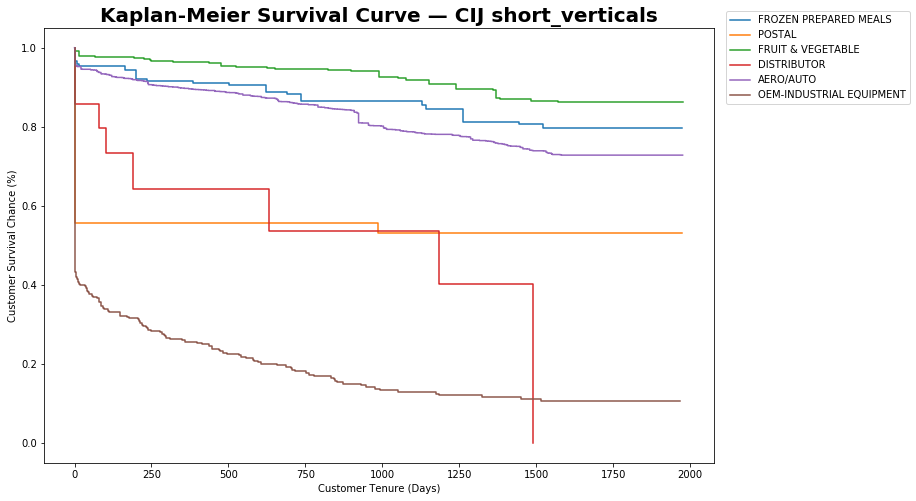

In [124]:
kmf1 = KaplanMeierFitter()
T_cij = cij['Duration'].values
E_cij = cij['Churn'].values
plt.figure(figsize=(12,8))
groups = cij['SHORT_VERTICAL'] 

i1 = (groups == 'FROZEN PREPARED MEALS')
kmf1.fit(T_cij[i1], E_cij[i1], label='FROZEN PREPARED MEALS')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'POSTAL')
kmf1.fit(T_cij[i2], E_cij[i2], label='POSTAL')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'FRUIT & VEGETABLE')
kmf1.fit(T_cij[i3], E_cij[i3], label='FRUIT & VEGETABLE')
a3 = kmf1.plot(ci_show=False)

i4 = (groups == 'DISTRIBUTOR')
kmf1.fit(T_cij[i4], E_cij[i4], label='DISTRIBUTOR')
a4 = kmf1.plot(ci_show=False)

i5 = (groups == 'AERO/AUTO')
kmf1.fit(T_cij[i5], E_cij[i5], label='AERO/AUTO')
a5 = kmf1.plot(ci_show=False)

i6 = (groups == 'OEM-INDUSTRIAL EQUIPMENT')
kmf1.fit(T_cij[i6], E_cij[i6], label='OEM-INDUSTRIAL EQUIPMENT')
a6 = kmf1.plot(ci_show=False)





plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — CIJ short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()  

In [127]:
cij.CONTRACT_CATEGORY.value_counts()

non-contract    26813
FSMA            20471
Full Care        3176
Supportive         49
WFC                 8
Name: CONTRACT_CATEGORY, dtype: int64

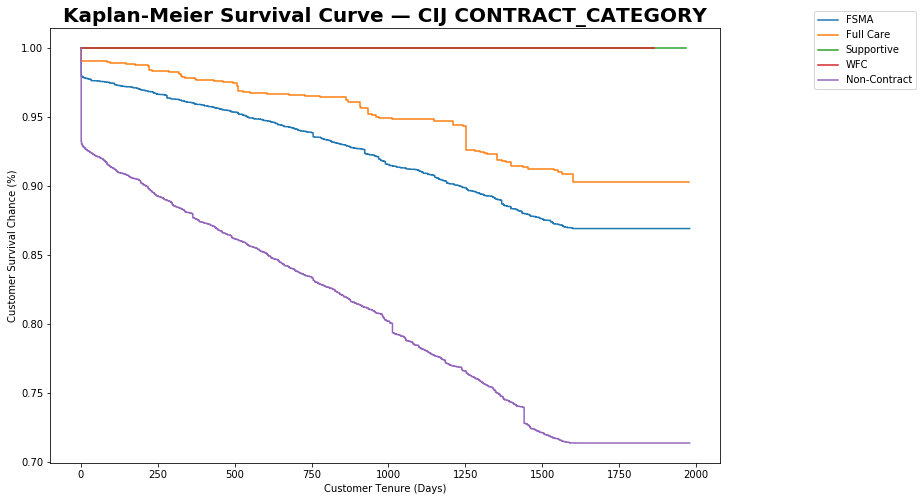

In [128]:
kmf1 = KaplanMeierFitter()
T_cij = cij['Duration'].values
E_cij = cij['Churn'].values
plt.figure(figsize=(12,8))
groups = cij['CONTRACT_CATEGORY'] 

i1 = (groups == 'FSMA')
kmf1.fit(T_cij[i1], E_cij[i1], label='FSMA')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'Full Care')
kmf1.fit(T_cij[i2], E_cij[i2], label='Full Care')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'Supportive')
kmf1.fit(T_cij[i3], E_cij[i3], label='Supportive')
a3 = kmf1.plot(ci_show=False)

i4 = (groups == 'WFC')
kmf1.fit(T_cij[i4], E_cij[i4], label='WFC')
a4 = kmf1.plot(ci_show=False)

i5 = (groups == 'non-contract')
kmf1.fit(T_cij[i5], E_cij[i5], label='Non-Contract')
a5 = kmf1.plot(ci_show=False)

plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — CIJ CONTRACT_CATEGORY',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()   

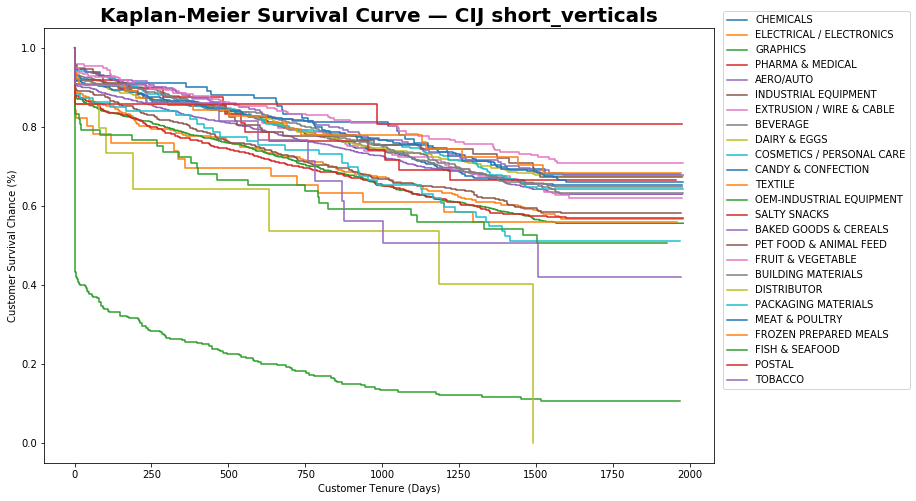

In [21]:
kmf1 = KaplanMeierFitter()
T_cij = cij['Duration'].values
E_cij = cij['Churn'].values
plt.figure(figsize=(12,8))
groups = cij['SHORT_VERTICAL'] 
i1 = (groups == 'CHEMICALS')
kmf1.fit(T_cij[i1], E_cij[i1], label='CHEMICALS')
a1 = kmf1.plot(ci_show=False)

vertical_list=[i for i in cij['SHORT_VERTICAL'].unique() if (i !='CHEMICALS' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list:
    groups = cij['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_cij[vertical], E_cij[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — CIJ short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()   

Text(0, 0.5, 'Customer Survival Chance (%)')

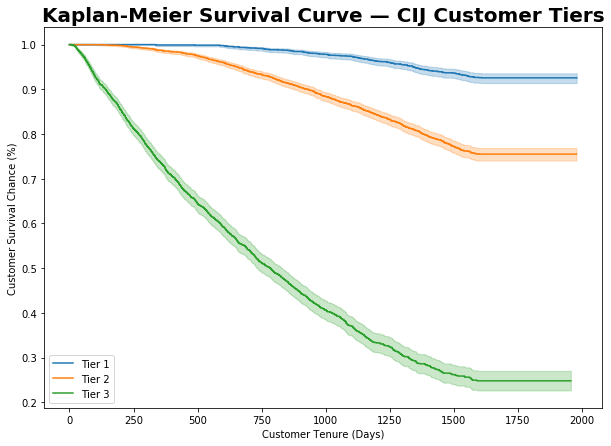

In [22]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = cij['Duration'].values
E = cij['Churn'].values

## Tiers are compared
groups = cij['Tier']   
i1 = (groups == 'Tier 1')   
i2 = (groups == 'Tier 2') 
i3 = (groups == 'Tier 3')     
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Tier 1')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Tier 2')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Tier 3')
kmf1.plot(ax=a1)


plt.legend(loc=3)
plt.title("Kaplan-Meier Survival Curve — CIJ Customer Tiers",weight='bold',size=20)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

In [23]:
cij['SHORT_VERTICAL'].value_counts().index.tolist()

['UNKNOWN',
 'OTHER',
 'GRAPHICS',
 'OTHER FOOD',
 'AERO/AUTO',
 'BEVERAGE',
 'PHARMA & MEDICAL',
 'DAIRY & EGGS',
 'INDUSTRIAL EQUIPMENT',
 'BUILDING MATERIALS',
 'OEM-INDUSTRIAL EQUIPMENT',
 'CHEMICALS',
 'MEAT & POULTRY',
 'ELECTRICAL / ELECTRONICS',
 'COSMETICS / PERSONAL CARE',
 'FRUIT & VEGETABLE',
 'BAKED GOODS & CEREALS',
 'EXTRUSION / WIRE & CABLE',
 'CANDY & CONFECTION',
 'PET FOOD & ANIMAL FEED',
 'PACKAGING MATERIALS',
 'FISH & SEAFOOD',
 'FROZEN PREPARED MEALS',
 'TEXTILE',
 'SALTY SNACKS',
 'TOBACCO',
 'POSTAL',
 'DISTRIBUTOR']

## tij

Text(0, 0.5, 'Customer Survival Chance (%)')

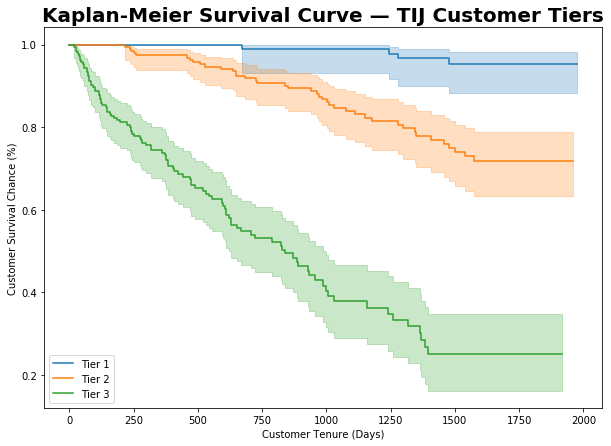

In [24]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = tij['Duration'].values
E = tij['Churn'].values

## Tiers are compared
groups = tij['Tier']   
i1 = (groups == 'Tier 1')   
i2 = (groups == 'Tier 2') 
i3 = (groups == 'Tier 3')     
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Tier 1')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Tier 2')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Tier 3')
kmf1.plot(ax=a1)


plt.legend(loc=3)
plt.title("Kaplan-Meier Survival Curve — TIJ Customer Tiers",weight='bold',size=20)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

In [129]:
tij['CONTRACT_CATEGORY'].value_counts()

non-contract    1555
FSMA             446
Full Care         29
Name: CONTRACT_CATEGORY, dtype: int64

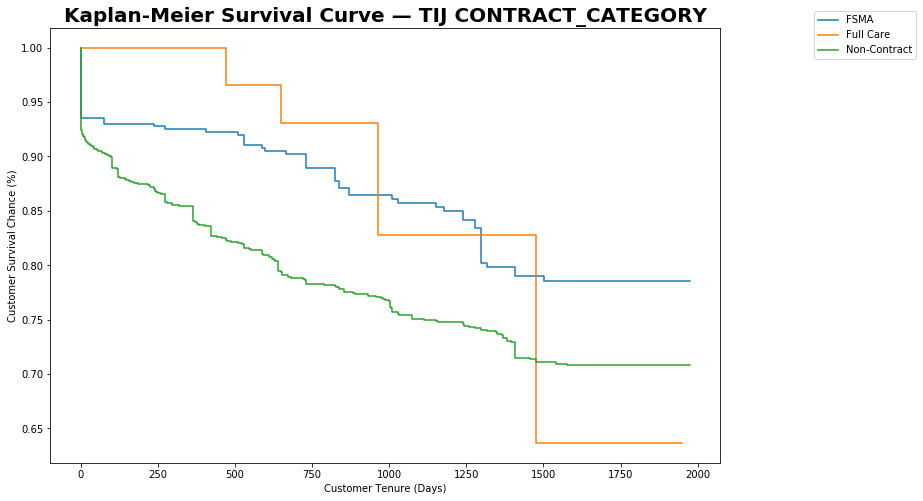

In [130]:
kmf1 = KaplanMeierFitter()
T_tij = tij['Duration'].values
E_tij = tij['Churn'].values
plt.figure(figsize=(12,8))
groups = tij['CONTRACT_CATEGORY'] 

i1 = (groups == 'FSMA')
kmf1.fit(T_tij[i1], E_tij[i1], label='FSMA')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'Full Care')
kmf1.fit(T_tij[i2], E_tij[i2], label='Full Care')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'non-contract')
kmf1.fit(T_tij[i3], E_tij[i3], label='Non-Contract')
a3 = kmf1.plot(ci_show=False)

plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — TIJ CONTRACT_CATEGORY',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()   

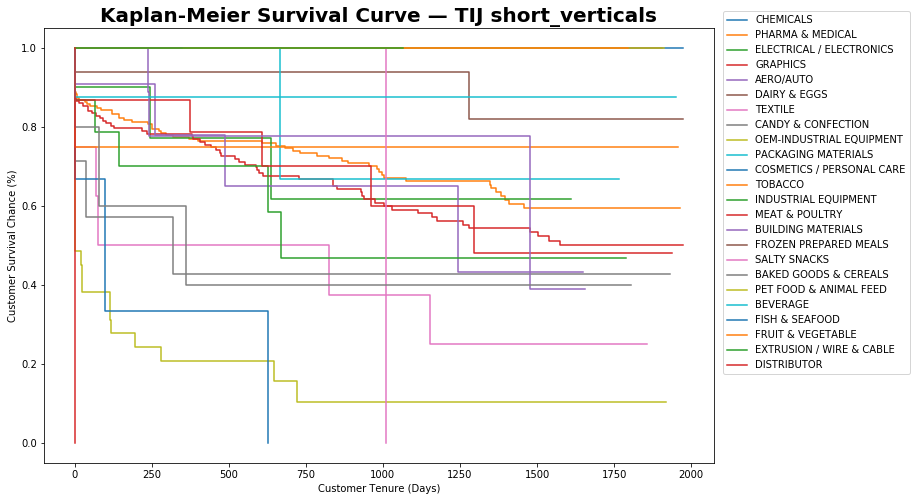

In [25]:
kmf1 = KaplanMeierFitter()
T_tij = tij['Duration'].values
E_tij = tij['Churn'].values
plt.figure(figsize=(12,8))
groups = tij['SHORT_VERTICAL'] 
i1 = (groups == 'CHEMICALS')
kmf1.fit(T_tij[i1], E_tij[i1], label='CHEMICALS')
a1 = kmf1.plot(ci_show=False)

vertical_list=[i for i in tij['SHORT_VERTICAL'].unique() if (i !='CHEMICALS' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list:
    groups = tij['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_tij[vertical], E_tij[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — TIJ short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()   

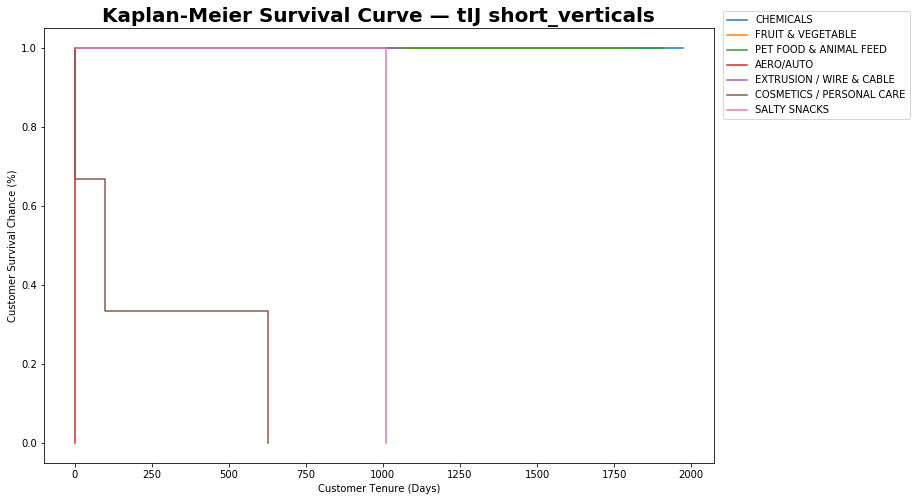

In [42]:
kmf1 = KaplanMeierFitter()
T_tij = tij['Duration'].values
E_tij = tij['Churn'].values
plt.figure(figsize=(12,8))
groups = tij['SHORT_VERTICAL'] 

i1 = (groups == 'CHEMICALS')
kmf1.fit(T_tij[i1], E_tij[i1], label='CHEMICALS')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'FRUIT & VEGETABLE')
kmf1.fit(T_tij[i2], E_tij[i2], label='FRUIT & VEGETABLE')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'PET FOOD & ANIMAL FEED')
kmf1.fit(T_tij[i3], E_tij[i3], label='PET FOOD & ANIMAL FEED')
a3 = kmf1.plot(ci_show=False)


i4 = (groups == 'DISTRIBUTOR')
kmf1.fit(T_tij[i4], E_tij[i4], label='AERO/AUTO')
a4 = kmf1.plot(ci_show=False)

i5 = (groups == 'EXTRUSION / WIRE & CABLE')
kmf1.fit(T_tij[i5], E_tij[i5], label='EXTRUSION / WIRE & CABLE')
a5 = kmf1.plot(ci_show=False)

i6 = (groups == 'COSMETICS / PERSONAL CARE')
kmf1.fit(T_tij[i6], E_tij[i6], label='COSMETICS / PERSONAL CARE')
a6 = kmf1.plot(ci_show=False)

i7 = (groups == 'SALTY SNACKS')
kmf1.fit(T_tij[i7], E_tij[i7], label='SALTY SNACKS')
a7 = kmf1.plot(ci_show=False)




plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — tIJ short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()  

In [27]:
 tij['SHORT_VERTICAL'].value_counts().index.tolist()

['PHARMA & MEDICAL',
 'GRAPHICS',
 'UNKNOWN',
 'OEM-INDUSTRIAL EQUIPMENT',
 'OTHER',
 'OTHER FOOD',
 'DAIRY & EGGS',
 'INDUSTRIAL EQUIPMENT',
 'MEAT & POULTRY',
 'AERO/AUTO',
 'ELECTRICAL / ELECTRONICS',
 'BUILDING MATERIALS',
 'TEXTILE',
 'BEVERAGE',
 'CANDY & CONFECTION',
 'BAKED GOODS & CEREALS',
 'CHEMICALS',
 'TOBACCO',
 'FROZEN PREPARED MEALS',
 'PACKAGING MATERIALS',
 'PET FOOD & ANIMAL FEED',
 'COSMETICS / PERSONAL CARE',
 'DISTRIBUTOR',
 'EXTRUSION / WIRE & CABLE',
 'FISH & SEAFOOD',
 'FRUIT & VEGETABLE',
 'SALTY SNACKS']

## lcm

Text(0, 0.5, 'Customer Survival Chance (%)')

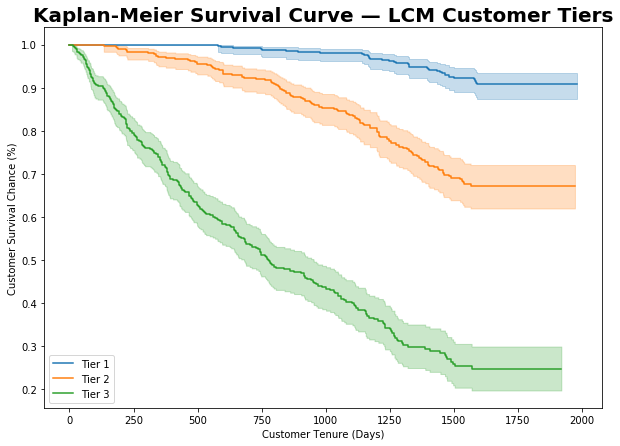

In [28]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = lcm['Duration'].values
E = lcm['Churn'].values

## Tiers are compared
groups = lcm['Tier']   
i1 = (groups == 'Tier 1')   
i2 = (groups == 'Tier 2') 
i3 = (groups == 'Tier 3')     
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Tier 1')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Tier 2')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Tier 3')
kmf1.plot(ax=a1)


plt.legend(loc=3)
plt.title("Kaplan-Meier Survival Curve — LCM Customer Tiers",weight='bold',size=20)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

In [131]:
lcm['CONTRACT_CATEGORY'].value_counts()

non-contract    8885
FSMA            4083
Full Care        789
Supportive         9
Name: CONTRACT_CATEGORY, dtype: int64

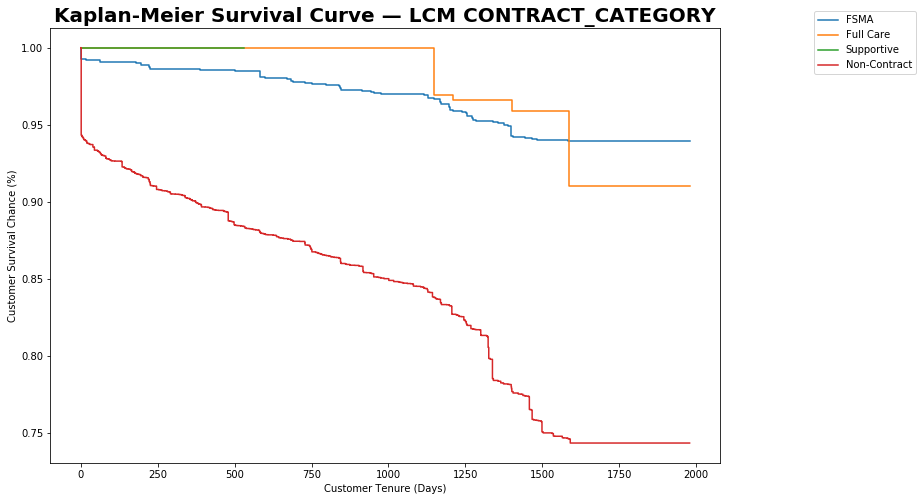

In [132]:
kmf1 = KaplanMeierFitter()
T_lcm = lcm['Duration'].values
E_lcm = lcm['Churn'].values
plt.figure(figsize=(12,8))
groups = lcm['CONTRACT_CATEGORY'] 

i1 = (groups == 'FSMA')
kmf1.fit(T_lcm[i1], E_lcm[i1], label='FSMA')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'Full Care')
kmf1.fit(T_lcm[i2], E_lcm[i2], label='Full Care')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'Supportive')
kmf1.fit(T_lcm[i3], E_lcm[i3], label='Supportive')
a3 = kmf1.plot(ci_show=False)

i4 = (groups == 'non-contract')
kmf1.fit(T_lcm[i4], E_lcm[i4], label='Non-Contract')
a4 = kmf1.plot(ci_show=False)

plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — LCM CONTRACT_CATEGORY',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show() 

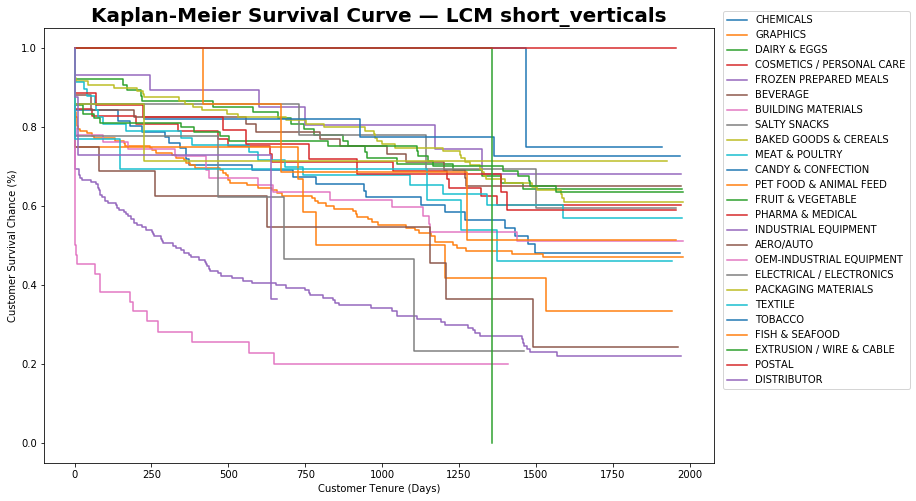

In [29]:
kmf1 = KaplanMeierFitter()
T_lcm = lcm['Duration'].values
E_lcm = lcm['Churn'].values
plt.figure(figsize=(12,8))
groups = lcm['SHORT_VERTICAL'] 
i1 = (groups == 'CHEMICALS')
kmf1.fit(T_lcm[i1], E_lcm[i1], label='CHEMICALS')
a1 = kmf1.plot(ci_show=False)

vertical_list=[i for i in lcm['SHORT_VERTICAL'].unique() if (i !='CHEMICALS' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list:
    groups = lcm['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_lcm[vertical], E_lcm[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — LCM short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()   

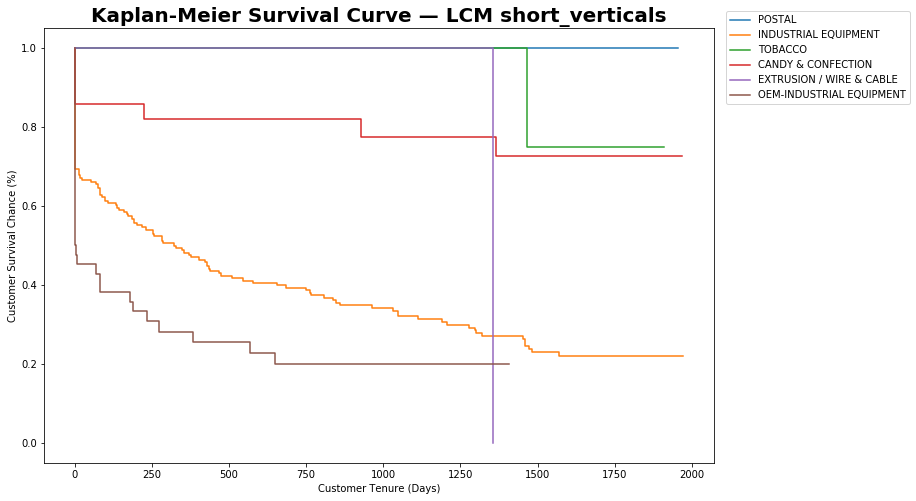

In [45]:
kmf1 = KaplanMeierFitter()
T_lcm = lcm['Duration'].values
E_lcm = lcm['Churn'].values
plt.figure(figsize=(12,8))
groups = lcm['SHORT_VERTICAL'] 

i1 = (groups == 'POSTAL')
kmf1.fit(T_lcm[i1], E_lcm[i1], label='POSTAL')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'INDUSTRIAL EQUIPMENT')
kmf1.fit(T_lcm[i2], E_lcm[i2], label='INDUSTRIAL EQUIPMENT')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'TOBACCO')
kmf1.fit(T_lcm[i3], E_lcm[i3], label='TOBACCO')
a3 = kmf1.plot(ci_show=False)

i4 = (groups == 'CANDY & CONFECTION')
kmf1.fit(T_lcm[i4], E_lcm[i4], label='CANDY & CONFECTION')
a4 = kmf1.plot(ci_show=False)

i5 = (groups == 'EXTRUSION / WIRE & CABLE')
kmf1.fit(T_lcm[i5], E_lcm[i5], label='EXTRUSION / WIRE & CABLE')
a5 = kmf1.plot(ci_show=False)

i6 = (groups == 'OEM-INDUSTRIAL EQUIPMENT')
kmf1.fit(T_lcm[i6], E_lcm[i6], label='OEM-INDUSTRIAL EQUIPMENT')
a6 = kmf1.plot(ci_show=False)

plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — LCM short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show() 

In [31]:
lcm['SHORT_VERTICAL'].value_counts().index.tolist()

['OTHER FOOD',
 'INDUSTRIAL EQUIPMENT',
 'GRAPHICS',
 'BAKED GOODS & CEREALS',
 'UNKNOWN',
 'OTHER',
 'FRUIT & VEGETABLE',
 'CHEMICALS',
 'DAIRY & EGGS',
 'BUILDING MATERIALS',
 'COSMETICS / PERSONAL CARE',
 'BEVERAGE',
 'MEAT & POULTRY',
 'OEM-INDUSTRIAL EQUIPMENT',
 'PHARMA & MEDICAL',
 'FROZEN PREPARED MEALS',
 'CANDY & CONFECTION',
 'AERO/AUTO',
 'SALTY SNACKS',
 'TEXTILE',
 'PET FOOD & ANIMAL FEED',
 'ELECTRICAL / ELECTRONICS',
 'DISTRIBUTOR',
 'FISH & SEAFOOD',
 'PACKAGING MATERIALS',
 'TOBACCO',
 'EXTRUSION / WIRE & CABLE',
 'POSTAL']

## tto

Text(0, 0.5, 'Customer Survival Chance (%)')

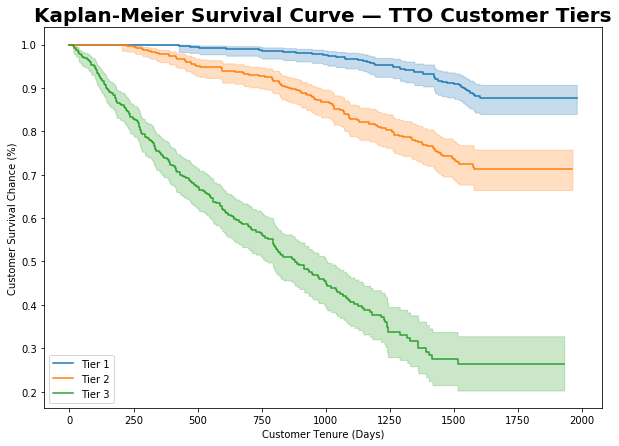

In [32]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
T = tto['Duration'].values
E = tto['Churn'].values

## Tiers are compared
groups = tto['Tier']   
i1 = (groups == 'Tier 1')   
i2 = (groups == 'Tier 2') 
i3 = (groups == 'Tier 3')     
    

fig, ax = plt.subplots(figsize=(10,7))

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Tier 1')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Tier 2')
kmf1.plot(ax=a1)

## fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Tier 3')
kmf1.plot(ax=a1)


plt.legend(loc=3)
plt.title("Kaplan-Meier Survival Curve — TTO Customer Tiers",weight='bold',size=20)
ax.set_xlabel('Customer Tenure (Days)')
ax.set_ylabel('Customer Survival Chance (%)')

In [133]:
tto['CONTRACT_CATEGORY'].value_counts()

non-contract    8450
FSMA            4333
Full Care        510
Name: CONTRACT_CATEGORY, dtype: int64

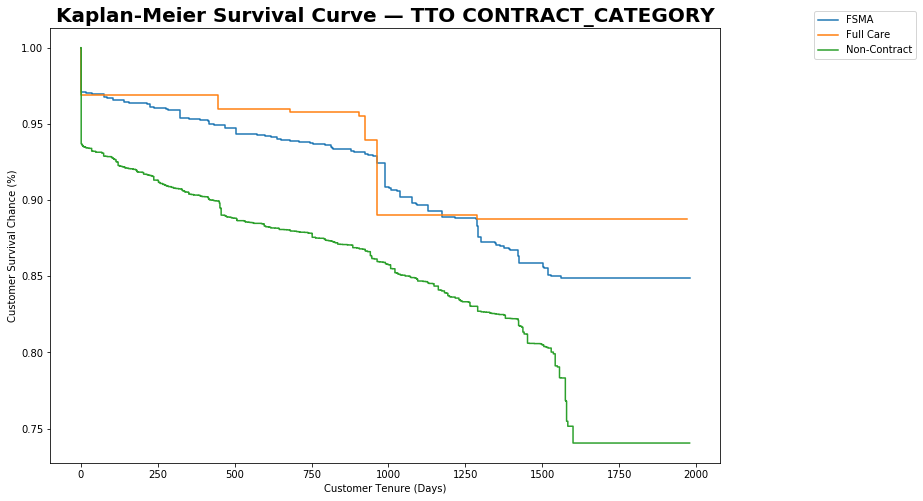

In [135]:
kmf1 = KaplanMeierFitter()
T_tto = tto['Duration'].values
E_tto = tto['Churn'].values
plt.figure(figsize=(12,8))
groups = tto['CONTRACT_CATEGORY'] 

i1 = (groups == 'FSMA')
kmf1.fit(T_tto[i1], E_tto[i1], label='FSMA')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'Full Care')
kmf1.fit(T_tto[i2], E_tto[i2], label='Full Care')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'non-contract')
kmf1.fit(T_tto[i3], E_tto[i3], label='Non-Contract')
a3 = kmf1.plot(ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — TTO CONTRACT_CATEGORY',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show() 

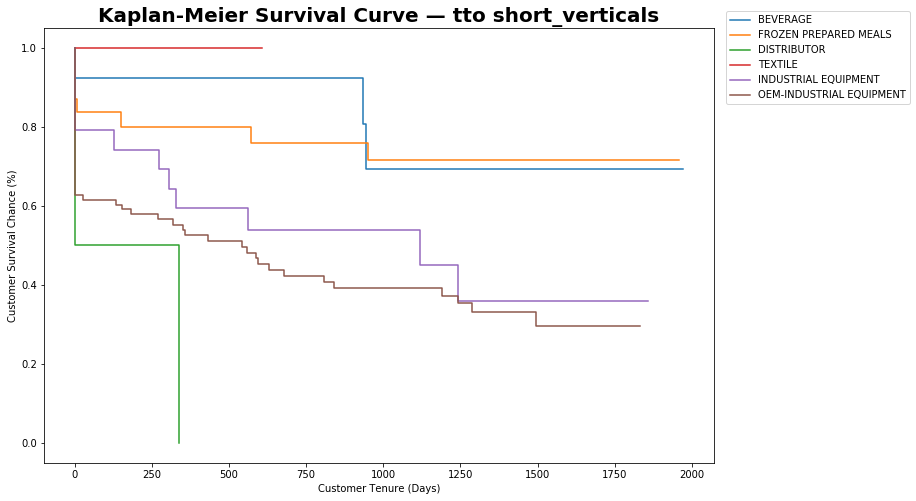

In [46]:
kmf1 = KaplanMeierFitter()
T_tto = tto['Duration'].values
E_tto = tto['Churn'].values
plt.figure(figsize=(12,8))
groups = tto['SHORT_VERTICAL'] 

i1 = (groups == 'BEVERAGE')
kmf1.fit(T_tto[i1], E_tto[i1], label='BEVERAGE')
a1 = kmf1.plot(ci_show=False)

i2 = (groups == 'FROZEN PREPARED MEALS')
kmf1.fit(T_tto[i2], E_tto[i2], label='FROZEN PREPARED MEALS')
a2 = kmf1.plot(ci_show=False)

i3 = (groups == 'DISTRIBUTOR')
kmf1.fit(T_tto[i3], E_tto[i3], label='DISTRIBUTOR')
a3 = kmf1.plot(ci_show=False)

i4 = (groups == 'TEXTILE')
kmf1.fit(T_tto[i4], E_tto[i4], label='TEXTILE')
a4 = kmf1.plot(ci_show=False)

i5 = (groups == 'INDUSTRIAL EQUIPMENT')
kmf1.fit(T_tto[i5], E_tto[i5], label='INDUSTRIAL EQUIPMENT')
a5 = kmf1.plot(ci_show=False)

i6 = (groups == 'OEM-INDUSTRIAL EQUIPMENT')
kmf1.fit(T_tto[i6], E_tto[i6], label='OEM-INDUSTRIAL EQUIPMENT')
a6 = kmf1.plot(ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — tto short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show()  

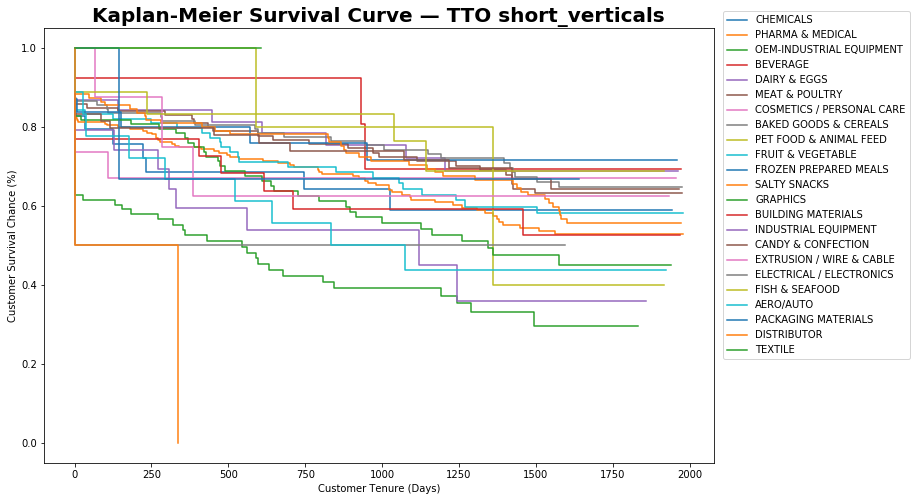

In [34]:
kmf1 = KaplanMeierFitter()
T_tto = tto['Duration'].values
E_tto = tto['Churn'].values
plt.figure(figsize=(12,8))
groups = tto['SHORT_VERTICAL'] 
i1 = (groups == 'CHEMICALS')
kmf1.fit(T_tto[i1], E_tto[i1], label='CHEMICALS')
a1 = kmf1.plot(ci_show=False)

vertical_list=[i for i in tto['SHORT_VERTICAL'].unique() if (i !='CHEMICALS' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list:
    groups = tto['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_tto[vertical], E_tto[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)


plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — TTO short_verticals',weight='bold',size=20)

plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show() 

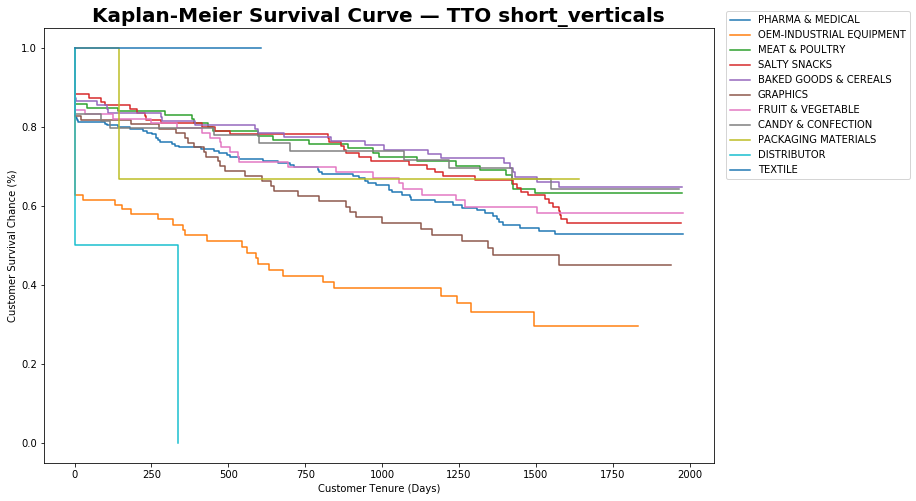

In [35]:
kmf1 = KaplanMeierFitter()
T_tto = tto['Duration'].values
E_tto = tto['Churn'].values
plt.figure(figsize=(12,8))
groups = tto['SHORT_VERTICAL'] 
i1 = (groups == 'PHARMA & MEDICAL')
kmf1.fit(T_tto[i1], E_tto[i1], label='PHARMA & MEDICAL')
a1 = kmf1.plot(ci_show=False)

vertical_list=[i for i in tto['SHORT_VERTICAL'].value_counts().index.tolist()[:11] if (i != 'PHARMA & MEDICAL' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list:
    groups = tto['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_tto[vertical], E_tto[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)

vertical_list1=[i for i in tto['SHORT_VERTICAL'].value_counts().index.tolist()[-3:] if (i != 'PHARMA & MEDICAL' and i !='UNKNOWN' and i !='OTHER' and i !='OTHER FOOD')]
for i in vertical_list1:
    groups = tto['SHORT_VERTICAL'] 
    vertical = (groups == i)
    kmf1.fit(T_tto[vertical], E_tto[vertical], label=i)
    kmf1.plot(ax=a1,ci_show=False)

plt.legend(loc=1,bbox_to_anchor=(1.3, 1.05))
plt.title('Kaplan-Meier Survival Curve — TTO short_verticals',weight='bold',size=20)
plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Customer Survival Chance (%)')
plt.show() 

In [36]:
tto['SHORT_VERTICAL'].value_counts().index.tolist()

['OTHER FOOD',
 'UNKNOWN',
 'PHARMA & MEDICAL',
 'OEM-INDUSTRIAL EQUIPMENT',
 'MEAT & POULTRY',
 'SALTY SNACKS',
 'OTHER',
 'BAKED GOODS & CEREALS',
 'GRAPHICS',
 'FRUIT & VEGETABLE',
 'CANDY & CONFECTION',
 'DAIRY & EGGS',
 'FROZEN PREPARED MEALS',
 'CHEMICALS',
 'BUILDING MATERIALS',
 'INDUSTRIAL EQUIPMENT',
 'COSMETICS / PERSONAL CARE',
 'AERO/AUTO',
 'FISH & SEAFOOD',
 'BEVERAGE',
 'EXTRUSION / WIRE & CABLE',
 'ELECTRICAL / ELECTRONICS',
 'PET FOOD & ANIMAL FEED',
 'PACKAGING MATERIALS',
 'DISTRIBUTOR',
 'TEXTILE']